## H2O-3 Regression Tutorial

[**1B. Introduction to Machine Learning with H2O-3 - Regression**](https://training.h2o.ai/products/1b-introduction-to-machine-learning-with-h2o-3-regression)に沿ったチュートリアル

[**H2O 3 - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)  
[**Python - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)

注意：[XGBoost(H2OXGBoostEstimator)はWindows上で動作しない](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#limitations)

#### 目次
- [Initial Setup](#InitialSetup)
    - パッケージのインポート
    - H2Oクラスターの開始
    - データのロード
- [Start Experiment](#StartExperiment)
    - データの確認
    - 学習(train)/検証(valid)/テスト(test)データセットへの分割
    - 利用変数の定義
- [Build an XGBoost Model](#BuildXGBoostModel)
    - XXX
- [Tune the XGBoost Model with H2O GridSearch](#TuneXGBoostModelGridSearch)
    - XXX
- [Test Set Performance](#TestSetPerformance)
    - XXX
    - H2Oクラスターの停止
- [H2O-3の特徴](#H2O-3の特徴)

***

<a id='InitialSetup'></a>
### Initial Setup

In [2]:
#Import H2O and other libraries that will be used in this tutorial 
import h2o
import matplotlib as plt
%matplotlib inline

#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [3]:
#> h2oパッケージのバージョン確認
print(h2o.__version__)

3.30.1.1


In [5]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\jpnyvs\AppData\Local\Continuum\anaconda3\envs\H2O_3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\jpnyvs\AppData\Local\Temp\tmpkerktnj7
  JVM stdout: C:\Users\jpnyvs\AppData\Local\Temp\tmpkerktnj7\h2o_jpnyvs_started_from_python.out
  JVM stderr: C:\Users\jpnyvs\AppData\Local\Temp\tmpkerktnj7\h2o_jpnyvs_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_jpnyvs_a4vmiv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.973 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
#> データのロード
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


連邦住宅金融抵当公庫(Freddie Mac)が提供する約20年間(1999/1-2018/12)の住宅ローン(Fixed-Rate Mortgages)の履歴データ。金利をターゲット変数として回帰の説明に使用する。  
  
[Data Reference](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)  
[変数等データ詳細に関して](http://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf)  
  
行数:500,137、列数:27（約80MB）

***

<a id='StartExperiment'></a>
### Start Experiment

In [7]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


金利(ORIGINAL_INTEREST_RATE)の分布の確認

In [8]:
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.18268686379932
maxs,11.5
sigma,0.5799408623980559
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


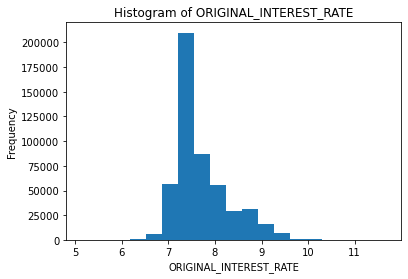

In [9]:
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [10]:
#> 学習/検証/テストデータセットへの分割（学習 : 検証 : テスト = 70% : 15% : 15%）
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)
print("＜train/valid/testのデータ数＞")
print( "train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows ))

＜train/valid/testのデータ数＞
train:350268 valid:74971 test:74898


In [11]:
#> ターゲット変数、特徴量の定義
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))
print(x)

['SERVICER_NAME', 'ORIGINAL_LOAN_TO_VALUE', 'ORIGINAL_LOAN_TERM', 'NUMBER_OF_UNITS', 'CHANNEL', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'SELLER_NAME', 'PROPERTY_STATE', 'METROPOLITAN_STATISTICAL_AREA', 'LOAN_PURPOSE', 'NUMBER_OF_BORROWERS', 'PROPERTY_TYPE', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'OCCUPANCY_STATUS', 'POSTAL_CODE', 'CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'ORIGINAL_UPB']


In [13]:
loan_level[x].describe()

Rows:500137
Cols:18




,SERVICER_NAME,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_LOAN_TERM,NUMBER_OF_UNITS,CHANNEL,ORIGINAL_COMBINED_LOAN_TO_VALUE,SELLER_NAME,PROPERTY_STATE,METROPOLITAN_STATISTICAL_AREA,LOAN_PURPOSE,NUMBER_OF_BORROWERS,PROPERTY_TYPE,ORIGINAL_DEBT_TO_INCOME_RATIO,OCCUPANCY_STATUS,POSTAL_CODE,CREDIT_SCORE,FIRST_TIME_HOMEBUYER_FLAG,ORIGINAL_UPB
type,enum,int,int,int,enum,int,enum,enum,int,enum,int,enum,int,enum,int,int,enum,int
mins,,6.0,301.0,1.0,,6.0,,,10180.0,,1.0,,1.0,,600.0,300.0,,8000.0
mean,,75.71071405720134,359.85546960132933,1.0288902574110141,,76.0535707144628,,,30777.82473929505,,1.6302946648262617,,32.917540518705366,,55490.85713828671,712.5362124215463,,136493.48478516893
maxs,,100.0,362.0,4.0,,180.0,,,49740.0,,2.0,,65.0,,99900.0,839.0,,578000.0
sigma,,14.937717088968684,1.908250710418729,0.21839057355939084,,15.1399860485127,,,11333.401144164458,,0.4827253530403165,,11.111799994455243,,29505.382258803038,54.79126197408829,,60968.74306564565
zeros,,0,0,0,,0,,,0,,0,,0,,0,0,,0
missing,0,9,0,3,0,13,0,0,70149,0,247,0,14929,0,31,2711,0,0
0,Other servicers,80.0,320.0,1.0,R,80.0,Other sellers,WV,nan,P,2.0,SF,33.0,O,26100.0,669.0,N,162000.0
1,Other servicers,25.0,360.0,1.0,R,25.0,Other sellers,OH,17140.0,N,1.0,SF,10.0,O,45200.0,732.0,N,53000.0
2,Other servicers,91.0,319.0,1.0,R,91.0,Other sellers,OH,15940.0,P,1.0,SF,48.0,O,44700.0,679.0,N,133000.0


<a id='BuildXGBoostModel'></a>
### Build an XGBoost Model

[**XGBoost - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#xgboost)  
[**H2OXGBoostEstimator - APIドキュメント**](XGBoost)
  
H2O XGBoostはH2Oクラスター上でオリジナルのXGBoost動作させるようビルドされたもの。カテゴリ変数の自動Encodingといった処理も含まれている。

オリジナルのXGBoostの[ドキュメンテーション](https://xgboost.readthedocs.io/en/latest/#)

In [16]:
xgb = H2OXGBoostEstimator(seed=42, model_id='XGBoost', nfolds=0, keep_cross_validation_predictions=False)

%time xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)    # Windowsではサポートされていない

H2OResponseError: Server error water.exceptions.H2ONotFoundArgumentException:
  Error: POST /3/ModelBuilders/xgboost not found
  Request: POST /3/ModelBuilders/xgboost
    data: {'seed': '42', 'model_id': 'XGBoost', 'nfolds': '0', 'keep_cross_validation_predictions': 'False', 'training_frame': 'py_10_sid_9bc9', 'validation_frame': 'py_11_sid_9bc9', 'response_column': 'ORIGINAL_INTEREST_RATE', 'ignored_columns': '["PREPAID","LOAN_SEQUENCE_NUMBER","PRODUCT_TYPE","MATURITY_DATE","DELINQUENT","FIRST_PAYMENT_DATE","PREPAYMENT_PENALTY_MORTGAGE_FLAG","MORTGAGE_INSURANCE_PERCENTAGE"]'}


In [17]:
#> H2Oクラスターの終了
h2o.cluster().shutdown()

H2O session _sid_9bc9 closed.
